# Implementing ViTs from Scratch

The tutorial we [followed](https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/11-vision-transformer.html) utilized the nn.MultiHeadAttention to compute attention. In this exposition, we will not abstract that out and implement the entire ViT from scratch. Code followed: [Implementing Vision Transformer](https://tintn.github.io/Implementing-Vision-Transformer-from-Scratch/). See also the associated [GitHub Respository](https://github.com/tintn/vision-transformer-from-scratch/blob/main/train.py)


### Imports and Dataset

In [1]:
import os
import json

import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10
import math

# Patch Embeddings

Take an image $X = \{H \times W \times C\} \in \mathbb{R}^{H \times W \times C}$ and divide the image into non-overlapping patches $(P, P)$ along the height and width. After this, we flatten each patch to obtain a collection of vectors where $ \text{flat}(p^i) = x_p^i \in \mathbb{R}^{P^2 C} $. In total, we obtain $N = HW/p^{2}$ patches. We then embed each patch by linearly projecting each vector into an Embedding space: $ T(x) = P(x) E_t$. The dimensions of E is $\mathbb{R}^{{P^2 C} \times d}$.




In context of CIFAR image, the dimensions of the original image is (32 x 32 x 3). We create (4 x 4 x 3) patches which when flattened produce patches of dimensionality 48. In total, 64 patches are created. We project these patches into the embedding dimension of size 256.


**Implementation**: We can use convolutions to create patches with the Kernel being identity. The stride of the convolutions would be equal to patch-size to obtain non-overlapping regions.


In [2]:
class PatchEmbeddings(nn.Module):
    """
    parameters: Image_size, patch_size, num_channels, embed_dim
    """

    def __init__(self, config):
        super().__init__()
        self.image_size = config["image_size"]
        self.patch_size = config["patch_size"]
        self.num_channels = config["num_channels"]
        self.embed = config["embed_dim"]

        # no. of patches from the image size and patch size
        self.num_patches = (self.image_size // self.patch_size) ** 2 # from (HW)/P^2

        # Create a projection layer to convert the image into patches
        # The layer projects each patch into a vector of size embed_dim
        self.projection = nn.Conv2d(self.num_channels, self.embed, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        # (batch_size, num_channels, image_size, image_size) -> (batch_size, num_patches, embed_dim)
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        return x

In [3]:
random_image_tensor = torch.randn(1, 3, 32, 32)
config = {
    "image_size": 32,
    "patch_size": 4,
    "num_channels": 3,
    "embed_dim": 256
}

patch_embeddings = PatchEmbeddings(config)
output = patch_embeddings(random_image_tensor)
output.shape

torch.Size([1, 64, 256])

In [ ]:
class Embeddings(nn.Module):
    """
    Combine the patch embeddings with the class token and position embeddings.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.patch_embeddings = PatchEmbeddings(config)

        # Creating a learnable [CLS] token


        # the nn.parameter creates a learnable tensor updated by backpropogation
        # we create a random vector from normal distribution along (1, 1, 48)

        self.cls_token = nn.Parameter(torch.randn(1, 1, config["embed_dim"]))

        # Creating learnable position embeddings for the [CLS] token and patches
        # Add 1 to the sequence length for the [CLS] token

        self.position_embeddings = \
            nn.Parameter(torch.randn(1, self.patch_embeddings.num_patches + 1, config["embed_dim"]))

        self.dropout = nn.Dropout(config["dropout_val"])

    def forward(self, x):

        x = self.patch_embeddings(x)
        batch_size, _, _ = x.size()

        # Expand the [CLS] token to the batch size
        # (1, 1, embed_dim) -> (batch_size, 1, embed_dim)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)

        # Concatenate the [CLS] token to the beginning of the input sequence
        # This results in a sequence length of (num_patches + 1)

        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.position_embeddings
        x = self.dropout(x)
        return x

# AttentionHead

This is a single-attention head used in multihead attention implementation.

In [ ]:
class AttentionHead(nn.Module):
    """
    A single attention head.
    This module is used in the MultiHeadAttention module.
    """
    def __init__(self, embed_dim, attention_head_dim, dropout, bias=True):
        super().__init__()
        self.embed = embed_dim
        self.attention_head_dim = attention_head_dim
        # Create the query, key, and value projection layers
        self.query = nn.Linear(embed_dim, attention_head_dim, bias=bias)
        self.key = nn.Linear(embed_dim, attention_head_dim, bias=bias)
        self.value = nn.Linear(embed_dim, attention_head_dim, bias=bias)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Project the input into query, key, and value
        # The same input is used to generate the query, key, and value,
        # so it's usually called self-attention.

        # (batch_size, sequence_length, embed_dim)
        # transforms to
        # -> (batch_size, sequence_length, attention_head_dim)


        query = self.query(x)
        key = self.key(x)
        value = self.value(x)


        # Calculate the attention scores
        # softmax(Q*K.T/sqrt(head_size))*V

        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_dim)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)

        # Calculate the attention output
        attention_output = torch.matmul(attention_probs, value)

        return (attention_output, attention_probs)

In [ ]:
class MultiHeadAttention(nn.Module):
    """
    Multi-head attention module.
    This module is used in the TransformerEncoder module.
    """

    def __init__(self, config):
        super().__init__()
        self.embed = config["embed_dim"]
        self.num_attention_heads = config["num_attention_heads"]
        # The attention head size is the hidden size divided by the number of attention heads
        self.attention_head_dim = self.embed // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_dim

        # Whether or not to use bias in the query, key, and value projection layers
        self.qkv_bias = config["qkv_bias"]

        # Create a list of attention heads

        self.heads = nn.ModuleList([])
        for _ in range(self.num_attention_heads):
            head = AttentionHead(
                self.embed,
                self.attention_head_dim,
                config["attention_probs_dropout_prob"],
                self.qkv_bias
            )
            self.heads.append(head)

        # Create a linear layer to project the attention output back to the hidden size
        # In most cases, all_head_size and embed_dim are the same
        self.output_projection = nn.Linear(self.all_head_size, self.embed)
        self.output_dropout = nn.Dropout(config["dropout_val"])

    def forward(self, x, output_attentions=False):
        # Calculate the attention output for each attention head
        attention_outputs = [head(x) for head in self.heads]
        # Concatenate the attention outputs from each attention head
        attention_output = torch.cat([attention_output for attention_output, _ in attention_outputs], dim=-1)
        # Project the concatenated attention output back to the hidden size
        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)
        # Return the attention output and the attention probabilities (optional)
        if not output_attentions:
            return (attention_output, None)
        else:
            attention_probs = torch.stack([attention_probs for _, attention_probs in attention_outputs], dim=1)
            return (attention_output, attention_probs)

In [ ]:
class MLP(nn.Module):
    """
    A multi-layer perceptron module.
    """

    def __init__(self, config):
        super().__init__()
        self.dense_1 = nn.Linear(config["embed_dim"], config["hidden_dim"])
        self.activation = nn.GELU()
        self.dense_2 = nn.Linear(config["hidden_dim"], config["embed_dim"])
        self.dropout = nn.Dropout(config["dropout_val"])

    def forward(self, x):
        x = self.dense_1(x)
        x = self.activation(x)
        x = self.dense_2(x)
        x = self.dropout(x)
        return x

In [ ]:
class Block(nn.Module):
    """
    A single transformer block.
    """

    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadAttention(config)
        self.layernorm_1 = nn.LayerNorm(config["embed_dim"])
        self.mlp = MLP(config)
        self.layernorm_2 = nn.LayerNorm(config["embed_dim"])

    def forward(self, x, output_attentions=False):
        # Self-attention
        attention_output, attention_probs = \
            self.attention(self.layernorm_1(x), output_attentions=output_attentions)
        # Skip connection
        x = x + attention_output
        # Feed-forward network
        mlp_output = self.mlp(self.layernorm_2(x))
        # Skip connection
        x = x + mlp_output
        # Return the transformer block's output and the attention probabilities (optional)
        if not output_attentions:
            return (x, None)
        else:
            return (x, attention_probs)

In [ ]:
class Encoder(nn.Module):
    """
    The transformer encoder module.
    """

    def __init__(self, config):
        super().__init__()
        # Create a list of transformer blocks
        self.blocks = nn.ModuleList([])
        for _ in range(config["num_hidden_layers"]):
            block = Block(config)
            self.blocks.append(block)

    def forward(self, x, output_attentions=False):
        # Calculate the transformer block's output for each block
        all_attentions = []
        for block in self.blocks:
            x, attention_probs = block(x, output_attentions=output_attentions)
            if output_attentions:
                all_attentions.append(attention_probs)
        # Return the encoder's output and the attention probabilities (optional)
        if not output_attentions:
            return (x, None)
        else:
            return (x, all_attentions)

In [ ]:
class ViTForClassification(nn.Module):
    """
    The ViT model for classification.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.image_size = config["image_size"]
        self.embed = config["embed_dim"]
        self.num_classes = config["num_classes"]
        # Create the embedding module
        self.embedding = Embeddings(config)
        # Create the transformer encoder module
        self.encoder = Encoder(config)
        # Create a linear layer to project the encoder's output to the number of classes
        self.classifier = nn.Linear(self.embed, self.num_classes)
        # Initialize the weights
        self.apply(self._init_weights)

    def forward(self, x, output_attentions=False):
        # Calculate the embedding output
        embedding_output = self.embedding(x)
        # Calculate the encoder's output
        encoder_output, all_attentions = self.encoder(embedding_output, output_attentions=output_attentions)
        # Calculate the logits, take the [CLS] token's output as features for classification
        logits = self.classifier(encoder_output[:, 0])
        # Return the logits and the attention probabilities (optional)
        if not output_attentions:
            return (logits, None)
        else:
            return (logits, all_attentions)
    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.normal_(module.weight, mean=0.0, std=self.config["initializer_range"])
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, Embeddings):
            module.position_embeddings.data = nn.init.trunc_normal_(
                module.position_embeddings.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.position_embeddings.dtype)

            module.cls_token.data = nn.init.trunc_normal_(
                module.cls_token.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.cls_token.dtype)

# Our Model Configuration and its size

Notice that in this case, the embed-dimension is 48 in contrast to 256 in the tutorial we followed. However, there is no **signifiant increase** in accuracy. but the number of parameters are very less for our Model. Its 111 k for our model in contrast to 3.2 M in the previous model.

In [ ]:
config = {
    "patch_size": 4,  # Input image size: 32x32 -> 8x8 patches
    "embed_dim": 48,
    "num_hidden_layers": 4,
    "num_attention_heads": 4,
    "hidden_dim": 4 * 48, # 4 * embed_dim
    "dropout_val": 0.0,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 10, # num_classes of CIFAR10
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
}
# These are not hard constraints, but are used to prevent misconfigurations
assert config["embed_dim"] % config["num_attention_heads"] == 0
assert config['hidden_dim'] == 4 * config['embed_dim']
assert config['image_size'] % config['patch_size'] == 0



# Model Size

Notice that in this case, the embed-dimension is 48 in contrast to 256 in the tutorial we followed. However, notice that there is no **signifiant increase** in accuracy. However, the number of parameters are very less. For this ViT, the number of parameters are 111 k which are insanely less than a 3.2 million ViT we just ran.

In [ ]:
from prettytable import PrettyTable

model = ViTForClassification(config)


def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params += param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model)


+-----------------------------------------------------+------------+
|                       Modules                       | Parameters |
+-----------------------------------------------------+------------+
|                 embedding.cls_token                 |     48     |
|            embedding.position_embeddings            |    3120    |
|     embedding.patch_embeddings.projection.weight    |    2304    |
|      embedding.patch_embeddings.projection.bias     |     48     |
|   encoder.blocks.0.attention.heads.0.query.weight   |    576     |
|    encoder.blocks.0.attention.heads.0.query.bias    |     12     |
|    encoder.blocks.0.attention.heads.0.key.weight    |    576     |
|     encoder.blocks.0.attention.heads.0.key.bias     |     12     |
|   encoder.blocks.0.attention.heads.0.value.weight   |    576     |
|    encoder.blocks.0.attention.heads.0.value.bias    |     12     |
|   encoder.blocks.0.attention.heads.1.query.weight   |    576     |
|    encoder.blocks.0.attention.he

119098

# Data Preperation and Defining Trainer

In [ ]:
def prepare_data(batch_size=4, num_workers=2, train_sample_size=None, test_sample_size=None):

  # TRAINING TRANSFORMATION

    train_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=train_transform)
    if train_sample_size is not None:
        # Randomly sample a subset of the training set
        indices = torch.randperm(len(trainset))[:train_sample_size]
        trainset = torch.utils.data.Subset(trainset, indices)



    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=num_workers)

    # TEST TRANSFORMATIONS

    test_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=test_transform)
    if test_sample_size is not None:
        # Randomly sample a subset of the test set
        indices = torch.randperm(len(testset))[:test_sample_size]
        testset = torch.utils.data.Subset(testset, indices)

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers)

    classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    return trainloader, testloader, classes





# Saving our Model

Since we would be carrying out various experiments throughout our project, we would like to learn how to save these models. In order to carry that out, the wonderful authors of this work defines these functions that we can then utilize.
Now, whenever we would run our model and complete the training, the model and other files will be stored in the virtual machine's file system where our Colab notebook is running. In particular, the model and data will be saved in a directory structure starting with a base directory named experiments, followed by subdirectories named according to the experiment name (e.g., ViT_CIFAR10) (just click on the folder button on the left).

In [ ]:
def save_experiment(experiment_name, config, model, train_losses, test_losses, accuracies, base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)

    # Save the config
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'w') as f:
        json.dump(config, f, sort_keys=True, indent=4)

    # Save the metrics
    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'w') as f:
        data = {
            'train_losses': train_losses,
            'test_losses': test_losses,
            'accuracies': accuracies,
        }
        json.dump(data, f, sort_keys=True, indent=4)

    # Save the model
    save_checkpoint(experiment_name, model, "final", base_dir=base_dir)


def save_checkpoint(experiment_name, model, epoch, base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)
    cpfile = os.path.join(outdir, f'model_{epoch}.pt')
    torch.save(model.state_dict(), cpfile)


def load_experiment(experiment_name, checkpoint_name="model_final.pt", base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    # Load the config
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'r') as f:
        config = json.load(f)
    # Load the metrics
    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'r') as f:
        data = json.load(f)
    train_losses = data['train_losses']
    test_losses = data['test_losses']
    accuracies = data['accuracies']
    # Load the model
    model = ViTForClassfication(config)
    cpfile = os.path.join(outdir, checkpoint_name)
    model.load_state_dict(torch.load(cpfile))
    return config, model, train_losses, test_losses, accuracies

# Trainer

Finally, with everything defined, we are ready to perform training.

In [ ]:
class Trainer:
    def __init__(self, model, optimizer, loss_fn, exp_name, device, base_dir="experiments"):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.exp_name = exp_name
        self.device = device
        self.base_dir = base_dir

    def train(self, trainloader, testloader, epochs, save_model_every_n_epochs=0):
        train_losses, test_losses, accuracies = [], [], []
        for i in range(epochs):
            train_loss = self.train_epoch(trainloader)
            accuracy, test_loss = self.evaluate(testloader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            accuracies.append(accuracy)
            print(f"Epoch: {i+1}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")

            # Save checkpoint if required
            if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0:
                save_checkpoint(self.exp_name, self.model, f"epoch_{i+1}", base_dir=self.base_dir)
                print(f'\tSaving checkpoint at epoch {i+1}')

        # Save the final model and experiment details at the end of training
        save_experiment(self.exp_name, config, self.model, train_losses, test_losses, accuracies, base_dir=self.base_dir)
        print(f'Final model and experiment details saved under {self.exp_name}')

    def train_epoch(self, trainloader):
        self.model.train()
        total_loss = 0
        for _, (images, labels) in enumerate(trainloader):
            images, labels = images.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()
            logits = self.model(images)[0]
            loss = self.loss_fn(logits, labels)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item() * len(images)
        return total_loss / len(trainloader.dataset)

    def evaluate(self, testloader):
        self.model.eval()
        total_loss, correct = 0, 0
        for _, (images, labels) in enumerate(testloader):
            images, labels = images.to(self.device), labels.to(self.device)
            logits, _ = self.model(images)
            loss = self.loss_fn(logits, labels)
            total_loss += loss.item() * len(images)
            predictions = torch.argmax(logits, dim=1)
            correct += torch.sum(predictions == labels).item()
        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)
        return accuracy, avg_loss

# Training our Model

In [ ]:
def main():
    # Configuration parameters
    exp_name = "ViT_CIFAR10"
    batch_size = 64
    epochs = 180
    lr = 0.01
    device = "cuda" if torch.cuda.is_available() else "cpu"
    save_model_every_n_epochs = 5

    trainloader, testloader, _ = prepare_data(batch_size)
    model = ViTForClassification(config)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    loss_fn = nn.CrossEntropyLoss()
    trainer = Trainer(model, optimizer, loss_fn, exp_name, device)
    trainer.train(trainloader, testloader, epochs, save_model_every_n_epochs)

if __name__ == "__main__":
    main()

100%|██████████| 170498071/170498071 [00:03<00:00, 43612446.39it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1, Train loss: 1.8454, Test loss: 1.5949, Accuracy: 0.4177
Epoch: 2, Train loss: 1.5175, Test loss: 1.4343, Accuracy: 0.4716
Epoch: 3, Train loss: 1.4126, Test loss: 1.3973, Accuracy: 0.4972
Epoch: 4, Train loss: 1.3378, Test loss: 1.3249, Accuracy: 0.5213
Epoch: 5, Train loss: 1.2779, Test loss: 1.2667, Accuracy: 0.5478
	Saving checkpoint at epoch 5
Epoch: 6, Train loss: 1.2163, Test loss: 1.2815, Accuracy: 0.5472
Epoch: 7, Train loss: 1.1744, Test loss: 1.1543, Accuracy: 0.5861
Epoch: 8, Train loss: 1.1430, Test loss: 1.1023, Accuracy: 0.6075
Epoch: 9, Train loss: 1.1147, Test loss: 1.1146, Accuracy: 0.5959
Epoch: 10, Train loss: 1.1000, Test loss: 1.1509, Accuracy: 0.5974
	Saving checkpoint at epoch 10
Epoch: 11, Train loss: 1.0767, Test loss: 1.1568, Accuracy: 0.5885
Epoch: 12, Train loss: 1.0648, Test loss: 1.0742, Accuracy: 0.6153
Epoch: 13, Train loss: 1.0540, Test loss: 1.0715, Accuracy: 0.6216
Epoch: 14, Train loss: 1.0466, Test loss: 1.1662, Accuracy: 0.5947
Epoch: 15,

# Visualizing Attention

We now visualize attention for a subset of images. We have explained in **Explainitity in ViT** how attention rollout works. Essentially, what the function does is that it concatenates attention maps across blocks. It also takes the classification token and averages it across all heads. The function plots each image side by side with its corresponding attention map overlay.

In [ ]:
import numpy as np

@torch.no_grad()
def visualize_attention(model, output=None, device="cuda"):
    """
    Visualize the attention maps of the first 4 images.
    """
    model.eval()
    # Load random images
    num_images = 30
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
    classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    # Pick 30 samples randomly
    indices = torch.randperm(len(testset))[:num_images]
    raw_images = [np.asarray(testset[i][0]) for i in indices]
    labels = [testset[i][1] for i in indices]
    # Convert the images to tensors
    test_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    images = torch.stack([test_transform(image) for image in raw_images])
    # Move the images to the device
    images = images.to(device)
    model = model.to(device)
    # Get the attention maps from the last block
    logits, attention_maps = model(images, output_attentions=True)
    # Get the predictions
    predictions = torch.argmax(logits, dim=1)
    # Concatenate the attention maps from all blocks
    attention_maps = torch.cat(attention_maps, dim=1)
    # select only the attention maps of the CLS token
    attention_maps = attention_maps[:, :, 0, 1:]
    # Then average the attention maps of the CLS token over all the heads
    attention_maps = attention_maps.mean(dim=1)
    # Reshape the attention maps to a square
    num_patches = attention_maps.size(-1)
    size = int(math.sqrt(num_patches))
    attention_maps = attention_maps.view(-1, size, size)
    # Resize the map to the size of the image
    attention_maps = attention_maps.unsqueeze(1)
    attention_maps = F.interpolate(attention_maps, size=(32, 32), mode='bilinear', align_corners=False)
    attention_maps = attention_maps.squeeze(1)
    # Plot the images and the attention maps
    fig = plt.figure(figsize=(20, 10))
    mask = np.concatenate([np.ones((32, 32)), np.zeros((32, 32))], axis=1)
    for i in range(num_images):
        ax = fig.add_subplot(6, 5, i+1, xticks=[], yticks=[])
        img = np.concatenate((raw_images[i], raw_images[i]), axis=1)
        ax.imshow(img)
        # Mask out the attention map of the left image
        extended_attention_map = np.concatenate((np.zeros((32, 32)), attention_maps[i].cpu()), axis=1)
        extended_attention_map = np.ma.masked_where(mask==1, extended_attention_map)
        ax.imshow(extended_attention_map, alpha=0.5, cmap='jet')
        # Show the ground truth and the prediction
        gt = classes[labels[i]]
        pred = classes[predictions[i]]
        ax.set_title(f"gt: {gt} / pred: {pred}", color=("green" if gt==pred else "red"))
    if output is not None:
        plt.savefig(output)
    plt.show()

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:153: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


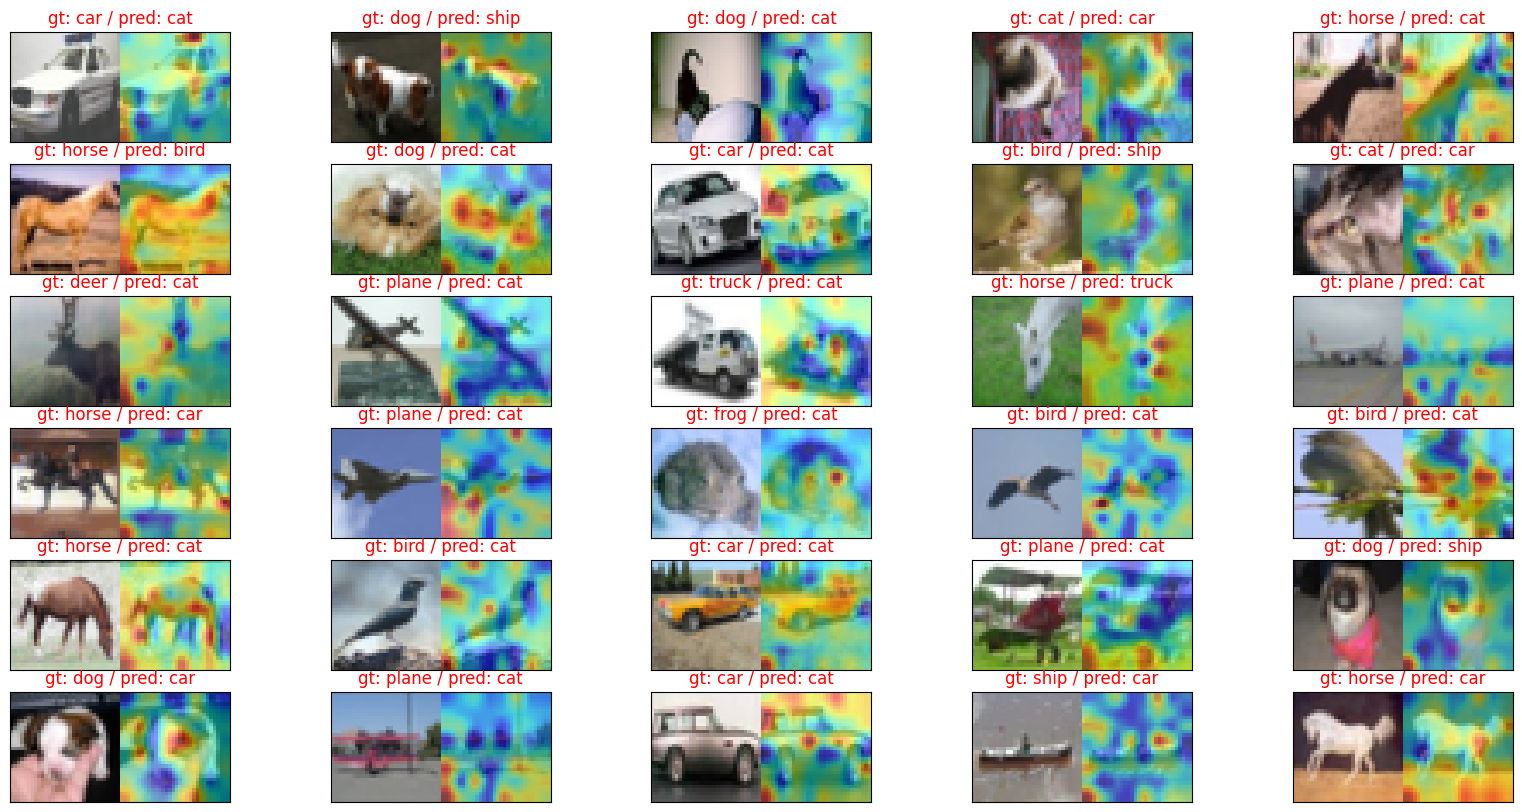

In [ ]:
visualize_attention(model, device="cuda")